# Part 1: Decision Trees

## Introduction

We can quickly use the sklearn library to build and use decision trees. For example,

```
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf = clf.fit(X, y)
```
<img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Petal-sepal.jpg" width="200" align="right" />

However this lab focuses on learning how the decision trees and random forests are built, by writing our own versions of these tools. In the real world you would be using a library, but the aim here is understanding the fundamentals of how these tools work.

This week I've included the answers to the exercises at the end of the document. Please still try to work out the answers yourself!

We will use as our purity metric the conditional entropy (as covered in the lecture).

We will use a discretised (binarised) version of the <a href="https://en.wikipedia.org/wiki/Iris_flower_data_set">iris dataset</a>. I've converted each of the continuous features to a binary feature, e.g. petal length is now 'long petal' (true/false). The labels are still three categories, either 'setosa', 'versicolor', 'virginica'. The task is to classify the species of Iris from four features (petal length, petal width, sepal length and sepal width).

I've tried to visualise this a little by plotting a bar graph for each class, with the number of rows for each feature being true. For example none of the 50 rows of the 'setosa' species have long sepals, while 88% of the rows of the virginica speices have long sepals.

long sepal    0.00
wide sepal    0.64
long petal    0.00
wide petal    0.00
dtype: float64
long sepal    0.52
wide sepal    0.04
long petal    0.08
wide petal    1.00
dtype: float64
long sepal    0.88
wide sepal    0.16
long petal    0.94
wide petal    1.00
dtype: float64


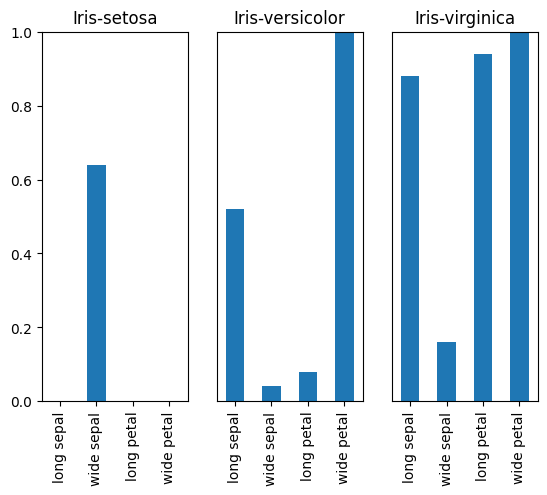

In [26]:
import pandas as pd # 引入 pandas 函式庫，用於資料處理
import matplotlib.pyplot as plt # 引入 matplotlib 的 pyplot 模組，用於繪圖
# 在 notebook 中直接顯示圖形
%matplotlib inline

# 從 Google Drive 下載並讀取特徵資料 X
X = pd.read_csv('https://drive.usercontent.google.com/download?id=1SHpvd9kee9eiAeviGfOgKR3SdOGfz8yM&export=download&authuser=0',index_col=0)
# 從 Google Drive 下載並讀取標籤資料 y
y = pd.read_csv('https://drive.usercontent.google.com/download?id=1SicnjGCccMnOETeAVA98iCq74cc8_OyD&export=download&authuser=0',index_col=0)

# 遍歷 y 中唯一的類別 (Iris 物種)
for i,v in enumerate(y['class'].unique()):
  plt.subplot(1,3,i+1) # 建立子圖，共 1 行 3 列
  plt.title(v) # 設定子圖標題為當前類別名稱
  print(X[y['class']==v].mean()) # 印出當前類別的特徵平均值
  X[y['class']==v].mean().plot.bar() # 繪製當前類別特徵平均值的長條圖
  plt.ylim([0,1]) # 設定 y 軸範圍為 0 到 1
  if i>0: plt.yticks([],[]) # 如果不是第一個子圖，則隱藏 y 軸刻度

## Entropy

We need to compute the entropy first.

---


### Exercise 1.1

Fill in the rest of this function with code to compute the entropy of the `ydata` column:

In [27]:
import numpy as np

def compute_entropy(ydata):
  """
  Returns the entropy of the labels in ydata (a pandas series) in bits.
  """
  p = ydata.value_counts()/len(ydata)
  return -np.sum(p*np.log2(p))



---

In [28]:
#To test you have coded this correctly, this synthetic test data should lead to
#an estimate of entropy of about 1.72957 bits
#as there are 6 red, 3 blue, 2 yellow, 1 orange. We can assume their probabilities,
#and from that compute the entropy:
#-((6/12)*np.log2(6/12) + (3/12)*np.log2(3/12) + (2/12)*np.log2(2/12) + (1/12)*np.log2(1/12))
testlabels = pd.DataFrame(['red','blue','blue','blue','red','red','yellow','red','red','red','yellow','orange'])
assert abs(compute_entropy(testlabels)-1.72957)<0.0001

#check your method computes the entropy correctly! The assertion will raise an
#AssertionError if it's wrong!

In [29]:
# We can compute the entropy of the Iris labels:
compute_entropy(y)

np.float64(1.584962500721156)

## Conditional Entropy

In the lecture, I wrote that the conditional entropy was,

$$-\sum\limits_{x \in X} \sum\limits_{y \in Y}p(x,y) \log_2 p(y|x)$$

but it will be slightly easier to code if we rewrite it like this:

First we use the product rule, $p(x,y) = p(y|x)p(x)$ to write the above as,

$$-\sum\limits_{x \in X} \sum\limits_{y \in Y}p(y|x)p(x) \log_2 p(y|x)$$

Then we note that $p(x)$ can move out of the inner summation, as it only depends on $x$:

$$-\sum\limits_{x \in X} p(x) \sum\limits_{y \in Y}p(y|x) \log_2 p(y|x)$$

So another way of writing the conditional entropy is "the expectation, over X, of the entropy of Y, given X".

Sort of like this (if it helps you remember),
$$
\mathbb{E}_X \Big[H(Y|X)\Big]
$$

This means you could write you conditional entropy function as:

1. loop over all the unique values in Xdata. Hint, try: `for v in Xdata.unique():`
2. For each one find the probability of the series having that value `np.mean(Xdata==v)`
3. Compute the entropy in ydata for just the rows in which Xdata is that value (`v`). You could do this by calling your `compute_entropy` method, with just the relevant values of ydata: `ydata[Xdata==v]`.
4. For each of the above compute the product of the probability you calculated in (2) and the entropy in (3), and sum them all, to get the expected entropy.
5. Return this sum.

---



### Exercise 1.2

Write a function to compute the conditional entropy,

In [30]:
def compute_conditional_entropy(Xdata,ydata):
  """Return the Conditional entropy of ydata given the series (aka 'column') Xdata

   - Xdata, a series (i.e. a single column) from a pandas dataframe, e.g. X['long petal']
   - ydata, the associated labels

  returns the conditional entropy H(Y|X)
  """
  sum_over_x = 0 # Initialize sum_over_x
  for v in Xdata.unique(): # 1.
    px = np.mean(Xdata==v)  # 2.
    sum_over_x += px*compute_entropy(ydata[Xdata==v]) # 3.4,
  return sum_over_x # 5.

---

In [31]:
testdata = pd.Series([False,True,True,True,False,False,True,False,False,False,True,True])
testlabels = pd.DataFrame(['red','blue','blue','blue','red','red','yellow','red','red','red','yellow','orange'])

#this testdata is 'false' when the labels were red, and true otherwise:
#so if false the entropy will be zero; if true, the entropy will be:
#3 blue, 2 yellow, 1 orange
#-(3/6 * np.log2(3/6) + 2/6 * np.log2(2/6) + 1/6 * np.log2(1/6))
#1.4591479170272448
#so the conditional entropy will be 0.5 * 0 + 0.5 * 1.45915 = 0.72957.

assert abs(compute_conditional_entropy(testdata,testlabels)-0.72957)<0.0001


Here we use the two methods you have written to compute the mutual information (information gain) for each of the features.

---

### Exercise 1.3

Can you finish off this method, what is missing?

Hint:
- We're computing $H(Y) - H(Y|X)$.
- $H(Y)$ is stored in `H_Y`.
- $H(Y|X)$ can be computed using `compute_conditional_entropy(Xdata[col],ydata)`.

In [32]:
def compute_mutual_infos(Xdata,ydata):
  """
  For each column in Xdata, compute the mutual information with ydata
  (also known as information gain):

     H(Y) - H(Y|X_column)

  returns a pandas series with the mutual information for each column.
  """
  # 先計算目標變數 ydata 的總熵 H(Y)
  H_Y = compute_entropy(ydata)

  # 建立一個空字典來儲存每欄的互資訊
  mutual_infos = {}
  for col in Xdata.columns:
    mutual_infos[col] = H_Y - compute_conditional_entropy(Xdata[col],ydata)
  # 將結果從字典轉換成 pandas Series 並回傳
  return pd.Series(mutual_infos)

compute_mutual_infos(X,y)

,0
long sepal,0.487389
wide sepal,0.249022
long petal,0.681611
wide petal,0.918296


We now need to build the tree, at each split, we will pick the feature that has the greatest information gain:

In [33]:
def build_tree(Xdata,ydata,depth=np.inf):

  # 計算所有特徵與目標變數之間的互資訊 (資訊增益)
  mutual_infos = compute_mutual_infos(Xdata,ydata)

  # 選擇具有最大互資訊的特徵作為當前的分割特徵
  col = mutual_infos.idxmax()

  # 判斷終止條件：如果最大互資訊為零 (表示無法再進行有效分割)，
  # 或者達到最大深度，則返回當前節點中最多的類別作為預測結果
  if (mutual_infos[col]==0) or (depth<=0):
    return ydata.value_counts().idxmax()[0]

  # 建立一個字典來表示當前的樹節點，儲存分割特徵
  tree = {'split':col}

  # 遍歷分割特徵的所有唯一值
  for v in Xdata[col].unique():
    # 遞迴地建立子樹，只使用 Xdata 中該特徵等於當前值 v 的資料
    # 並將最大深度減一 (因為向下深入了一層)
    subtree = build_tree(Xdata[Xdata[col]==v],ydata[Xdata[col]==v],depth-1)

    # 將子樹添加到當前節點的字典中，以特徵值 v 作為鍵
    tree[v] = subtree

  # 返回建立好的樹節點 (及其所有子樹)
  return tree

# 使用訓練資料 (每隔一個資料點) 來訓練決策樹。最大深度設定為 2，也可以嘗試最大深度為 1。
tree = build_tree(X[::2],y[::2],2)
print(tree)

{'split': 'wide petal', np.False_: 'Iris-setosa', np.True_: {'split': 'long petal', np.False_: 'Iris-versicolor', np.True_: 'Iris-virginica'}}


In [34]:
def predict(tree,x):
  # 根據當前節點的分割特徵 (tree['split'])，取得輸入資料 x 中對應特徵的值
  # 然後根據這個特徵值，從當前節點的字典中取得對應的子樹或葉節點
  subtree = tree[x[tree['split']]]

  # 檢查取得的 subtree 是否為字串 (表示是葉節點，儲存了預測的類別)
  if isinstance(subtree, str):
    # 如果是字串，直接返回該類別作為預測結果
    return subtree
  else:
    # 如果不是字串 (表示是內部節點，是一個字典)，則遞迴地呼叫 predict 函式
    # 以這個 subtree 作為新的樹，並傳入相同的輸入資料 x，繼續向下遍歷樹
    return predict(subtree,x)

# 建立一個空列表來儲存對測試資料的預測結果
predictions = []

# 遍歷測試資料 (X 中每隔一個資料點，從第二個開始)
for i,xtest in X[1::2].iterrows():
  # 對每一個測試資料點 xtest，使用 predict 函式進行預測，並將結果加入 predictions 列表
  predictions.append(predict(tree,xtest))

# 計算預測結果與實際標籤的準確度
# predictions == y[1::2]['class'].values 會產生一個布林陣列 (True 表示預測正確，False 表示預測錯誤)
# np.mean() 計算布林陣列的平均值，即正確預測的比例 (準確度)
# 將準確度乘以 100 轉換為百分比，並格式化輸出到小數點後兩位
print("Accuracy: %0.2f%%" % (100*np.mean(predictions==y[1::2]['class'].values)))

Accuracy: 97.33%


## sklearn's decision tree

Let's compare this tree with that generated with sklearn.

In [35]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
clf = clf.fit(X[::2], y[::2])

We can see what sort of tree sklearn creates using its 'tree' methods. The plot is somewhat unclear, but one can (after a bit of thinking) see that this matches our own tree:

[Text(0.4, 0.8333333333333334, 'wide petal <= 0.5\nentropy = 1.585\nsamples = 75\nvalue = [25, 25, 25]\nclass = Iris-setosa'),
 Text(0.2, 0.5, 'entropy = 0.0\nsamples = 25\nvalue = [25, 0, 0]\nclass = Iris-setosa'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'long petal <= 0.5\nentropy = 1.0\nsamples = 50\nvalue = [0, 25, 25]\nclass = Iris-versicolor'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'entropy = 0.516\nsamples = 26\nvalue = [0, 23, 3]\nclass = Iris-versicolor'),
 Text(0.8, 0.16666666666666666, 'entropy = 0.414\nsamples = 24\nvalue = [0, 2, 22]\nclass = Iris-virginica')]

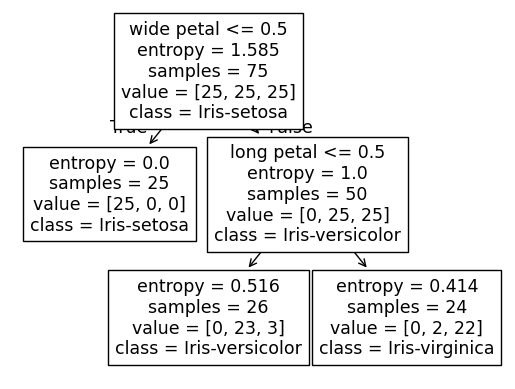

In [36]:
from sklearn import tree
tree.plot_tree(clf,feature_names=X.columns,class_names=y['class'].unique())

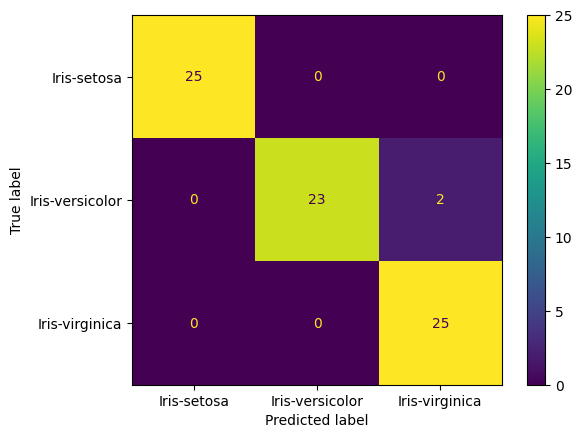

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y[1::2], clf.predict(X[1::2]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

# Part 2: Bootstrapping / Bagging

In the second half of this notebook we will look at applying the bootstrap sampling approach to a simple (one dimensional) regression problem.



## Bootstrapping applied to simple linear regression

We start with just a linear (1st-order "y = mx+c") fit to the data. Obviously we could use various library functions, but I'll try to keep the implementation within this notebook so you can see each step.

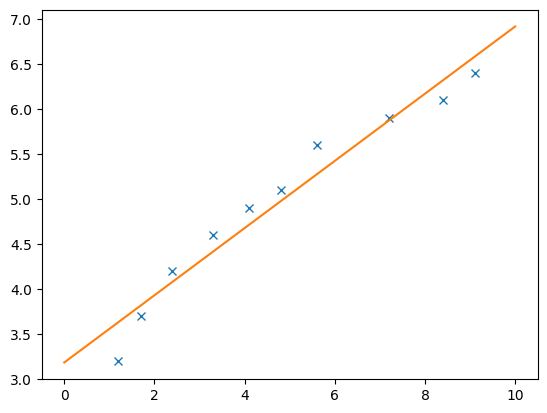

In [38]:
import numpy as np
import matplotlib.pyplot as plt

#our synthetic dataset
xvals = np.array([1.2,1.7,2.4,3.3,4.1,4.8,5.6,7.2,8.4,9.1])
yvals = np.array([3.2,3.7,4.2,4.6,4.9,5.1,5.6,5.9,6.1,6.4])

def fit_parameters(x,y):
  #Ordinary Least Squares fit to a 1st order polynomial
  # (straight-line).
  #Returns the two parameters as a numpy array
  # [gradient, offset]
  X = np.c_[x,np.ones_like(x)]
  return np.linalg.inv(X.T@X) @ X.T @ y

w = fit_parameters(xvals,yvals)
plt.plot(xvals,yvals,'x')
plt.plot([0,10],w[0]*np.array([0,10])+w[1])

---

### Exercise 2.1

We want to find out the uncertainty (given this model) on the range of possible predictions. To do this we will use bootstrapping and aggregation (bagging).

Complete the function below, you will need to:
1. Loop 1000 times...
2. For each iteration, select randomly *with replacement* ten of the values in x and y. Tip `np.random.choice(len(x),len(x))` might be useful!
3. For this selection compute $w$ using the `fit_parameters` method.
4. Add $w$ as another row in a matrix recording all the $w$s computed.
5. At the end of the loop there should be a $1000 \times 2$ matrix of values of $w$. Return this matrix.

In [39]:
def bootstrap(x,y):
  ws = [] # 沒嘉會錯誤是因為 bootstrap 函式中的列表沒有初始化，修正後可以正確繪製參數的散點圖。
  for i in range(1000): # 1.
    indices = np.random.choice(len(x),len(x)) # 2.
    w = fit_parameters(x[indices],y[indices]) # 3.
    #每次計算得到的這組兩個參數的陣列 (w) 都會被新增到 ws 這個列表中。迴圈結束後，ws 列表將包含 1000 個這樣的兩參數陣列
    ws.append(w)  # 4.
  return np.array(ws) # 5.

---

It can be informative to plot the distribution over $w$. This gives a sense of what sort of distribution it might be, etc.

Text(0, 0.5, 'Offset')

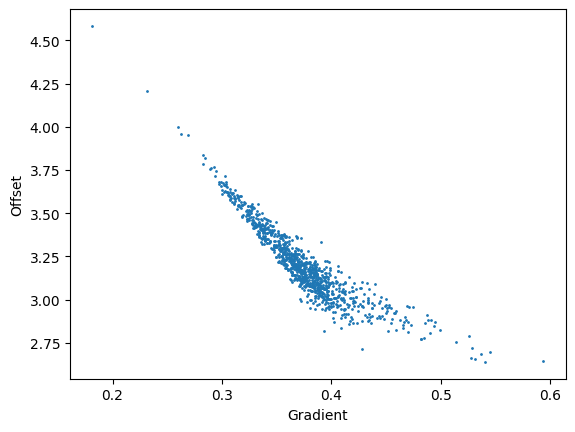

In [40]:
ws = bootstrap(xvals,yvals)
# 繪製 bootstrap 得到的參數 ws 的散點圖
plt.scatter(ws[:,0],ws[:,1],1)
# 設定 x 軸標籤為 'Gradient' (斜率)
plt.xlabel('Gradient')
# 設定 y 軸標籤為 'Offset' (截距)
plt.ylabel('Offset')

We can also plot the predictions on our normal xy graph. I'll just plot out 10% of them so the graph isn't overwhelmed. I've also drawn in the 95% credible interval for the predictions.

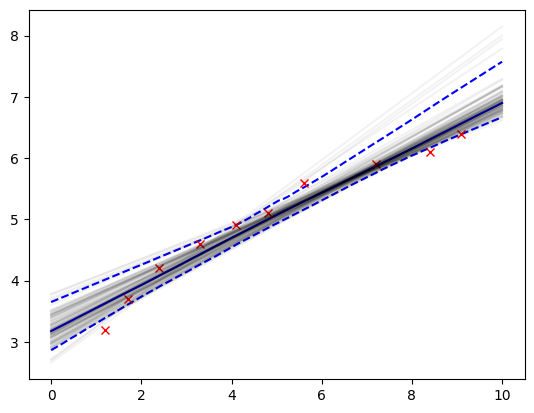

In [41]:
def plotCIs(x,y,ws):
  # 生成一組用於繪製信賴區間的測試 x 值
  testx = np.linspace(0,10,100)

  # 根據不同的 bootstrap 參數 ws，計算在 testx 上的預測值
  preds = ws[:,0:1]*testx[None,:]+ws[:,1:2]

  # 對預測值進行排序，以便後續計算信賴區間
  preds = np.sort(preds,0)

  # 繪製 2.5% 的信賴區間 (即第 25 個排序後的預測值)
  plt.plot(testx,preds[25,:],'b--')

  # 繪製中位數預測值 (即第 500 個排序後的預測值)
  plt.plot(testx,preds[500,:],'b-')

  # 繪製 97.5% 的信賴區間 (即第 975 個排序後的預測值)
  plt.plot(testx,preds[975,:],'b--')

  # 繪製原始資料點
  plt.plot(x,y,'xr')

  # 繪製 bootstrap 預測結果的 10% (每隔 10 個繪製一個)，使用較低的透明度
  for w in ws[::10]:
    plt.plot([0,10],[w[1],w[1]+w[0]*10],'k-',alpha=0.05)

# 呼叫 plotCIs 函式，使用原始資料和 bootstrap 得到的參數 ws 進行繪圖
plotCIs(xvals,yvals,ws)

## Decision trees and Bagging

Bagging helps when applied to the output of models or algorithms that are "unstable", e.g. decision trees, neural networks: These have high variance, but low bias. Linear regression on the other hand has fairly low variance (look how close the different results are above -- it is less likely to be sensitive to resampling).

We will now use bagging with simple 1-deep decision trees.

### Decision trees for a continuous input.

We have largely concerned ourselves with binary features. But if you remember in the lecture we briefly touched on continuous inputs and continuous outputs. The purity metric for continuous outputs is the expected variance; and to handle the input one selects a threshold for that feature that minimises the expected variances. The code below implements this:

In [42]:
def get_split(x,y):
  """This method finds the threshold value that minimises the weighted
  sum of variances between the two sub-nodes. It returns this threshold
  and the means of the two sub-nodes.
  """

  # 初始化最小加權方差為無限大
  minimum_var = np.inf
  # 初始化最佳閾值為 NaN
  minimum_threshold = np.nan
  # 遍歷從 0 到 10 的 100 個可能的閾值
  for threshold in np.linspace(0,10,100):
    # 計算基於當前閾值的加權方差總和
    weighted_sum_of_variance = np.var(y[y<threshold])*np.sum(y<threshold)+np.var(y[y>=threshold])*np.sum(y>=threshold)
    # 如果當前加權方差總和小於記錄的最小值
    if weighted_sum_of_variance<minimum_var:
      # 更新最小加權方差
      minimum_var = weighted_sum_of_variance
      # 更新最佳閾值
      minimum_threshold = threshold
  # 返回最佳閾值以及在該閾值左右兩邊資料的平均值
  return minimum_threshold, np.mean(y[x<minimum_threshold]), np.mean(y[x>=minimum_threshold])

(np.float64(4.646464646464646), np.float64(4.12), np.float64(5.82))


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


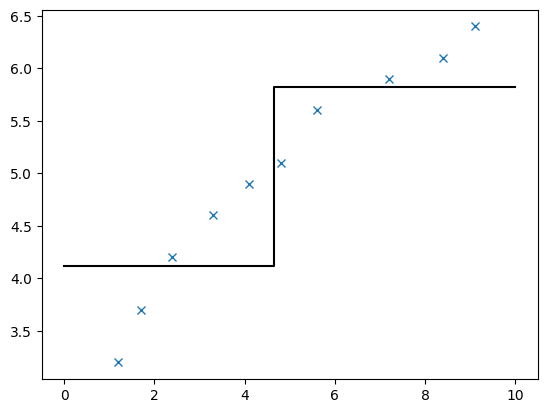

In [43]:
param  = get_split(xvals,yvals)
print(param)
plt.plot([0,param[0],param[0],10],[param[1],param[1],param[2],param[2]],'k-')
plt.plot(xvals,yvals,'x')

Two things to note:
1. The one-deep decision tree doesn't really seem to do a great job at prediction in this case.
2. It is probably going to be quite sensitive to resampling.

### Exercise 2.2.

Try writing a method that resamples 1000 times, with replacement, the points, and then for each resampled set, computes a new split (using the `get_split` method). Put all the parameters into a $1000 \times 3$ array. It is 3 wide as it includes the value of x where the tree splits the data, and includes the values on either side (left and right). Save in [splitLocation, leftValue, rightValue] order.

In [44]:
def bootstrap_trees(x,y):
  """
  執行 1000 次拔靴法抽樣，計算每次抽樣的最佳分割點，並回傳 1000x3 的結果陣列。
  """
  #Answer
  # 1. 建立儲存結果的容器
  results = np.zeros((1000, 3))

  # 2. 執行 1000 次迴圈
  for i in range(1000):
    # 2a. 產生一組隨機索引 (有放回)
    indices = np.random.choice(len(x), len(x))

    # 2b. 根據索引建立新的 x, y 子集
    # (假設 x 和 y 是 numpy 陣列或 pandas Series)
    x_subset = x[indices]
    y_subset = y[indices]

    # 2c. 對子集計算分割點
    split, left_mean, right_mean = get_split(x_subset, y_subset)

    # 2d. 儲存結果到第 i 列
    results[i] = [split, left_mean, right_mean]

  # 3. 回傳完整的結果陣列
  return results

In [45]:
parameters = bootstrap_trees(xvals,yvals)

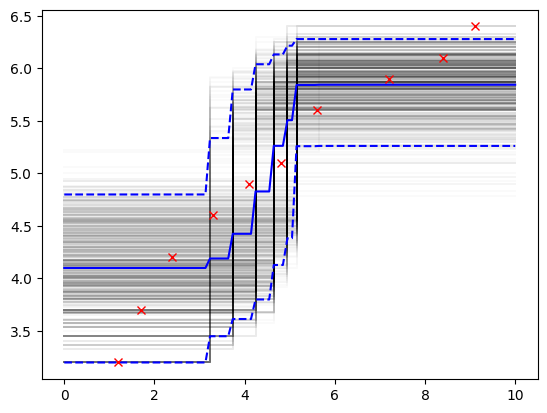

In [46]:
# Plot these predictions
for param in parameters:
  plt.plot([0,param[0],param[0],10],[param[1],param[1],param[2],param[2]],'k-',alpha=0.02)

#here we plot the 95% CI:
pred_x = np.linspace(0,10,100)
v = [np.nanmean(np.r_[parameters[p<parameters[:,0],1],parameters[p>=parameters[:,0],2]]) for p in pred_x]
lowerCI = [np.nanpercentile(np.r_[parameters[p<parameters[:,0],1],parameters[p>=parameters[:,0],2]],2.5) for p in pred_x]
upperCI = [np.nanpercentile(np.r_[parameters[p<parameters[:,0],1],parameters[p>=parameters[:,0],2]],97.5) for p in pred_x]
plt.plot(pred_x,v,'b-')
plt.plot(pred_x,lowerCI,'b--')
plt.plot(pred_x,upperCI,'b--')
plt.plot(xvals,yvals,'xr')

Argubly linear regression was a better model choice; however the mean of the ensemble is better than the single decision tree (feel free to check this!) and the model also provides uncertainty estimatation compared to a single tree.

# Part 3: Random Forest

We finally will apply what we have learnt to build a random forest.

This dataset is already very well separated with a simple decision tree, so a random forest is unlikely to help. We include the approach here purely for demonstrating how random forest works. Random forest is more effective where there is a greater risk of overfitting, and/or where many more features are available.


## Alternative tree-building method with subspace sampling

This method creates a tree as before, but at each node we only consider a random subset of the features. You can change the number of features chosen by changing `n=2` to, e.g. `n=1` in this line: `mutual_infos.sample(n=2)`.

In [47]:
def build_tree_with_subspace_sampling(Xdata,ydata,depth=np.inf):
  """
  This method builds a decision tree, but at each node, we only keep 2 of the
  four features. This is called "subspace sampling".
  """
  mutual_infos = compute_mutual_infos(Xdata,ydata)
  mutual_infos = mutual_infos.sample(n=2) #just keep two of the four features.
  col = mutual_infos.idxmax()
  if (mutual_infos[col]==0) or (depth<=0):
    return ydata.value_counts().idxmax()[0]

  tree = {'split':col}
  for v in Xdata[col].unique():
    subtree = build_tree(Xdata[Xdata[col]==v],ydata[Xdata[col]==v],depth-1)
    tree[v] = subtree

  return tree

#just using every other data point to train the tree. Max depth set to 2.
build_tree_with_subspace_sampling(X[::2],y[::2],2)

{'split': 'long petal',
 np.False_: {'split': 'wide petal',
  np.False_: 'Iris-setosa',
  np.True_: 'Iris-versicolor'},
 np.True_: {'split': 'wide sepal',
  np.False_: 'Iris-virginica',
  np.True_: 'Iris-virginica'}}

## Building the random forest

Let's now build our forest. Make lots of trees using the subspace sampling. Here we make 50 different trees, each one might be different from the others as at each branch of the tree, we could be using a different subset of features. A given, individual tree, will therefore probably be worse on the test data than the standard decision tee created above, however by making them have less correlation with each other, we are able to reduce our overall error on the test set. This seems somewhat counter-intuitive!

In [48]:
#Create 50 trees by calling build_tree_with_subspace_sampling
trees = []
for i in range(50):
  trees.append(build_tree_with_subspace_sampling(X[::2],y[::2],2))

#make predictions on each test item (the even items in the datasets)
predictions = []
for i,xtest in X[1::2].iterrows():
  singletree_predictions = []
  for tree in trees: #we record the predictions from all the individual trees...
    singletree_predictions.append(predict(tree,xtest))
  #we get the most popular prediction from all the trees in the random forest...
  predictions.append(max(set(singletree_predictions), key=singletree_predictions.count))

We can now compute the accuracy by looking at how many of our predictions matched the true label.

In [49]:
print("Accuracy: %0.2f%%" % (100*np.mean(predictions==y[1::2]['class'].values)))

Accuracy: 97.33%


To explore the random forest approach a little more,
- set the max-depth to 1
- use 500 trees (to reduce the variability)
- reduce the subspace sampling to just pick one feature instead of two.

How does the accuracy compare to the single decision tree (**with depth=1**)? Does the random forest do better than the single tree? (I've not included the answer below, maybe discuss with friends!).


# Answers


### Exercise 1.1

In [50]:
def compute_entropy(ydata):
  """
  Returns the entropy of the labels in ydata (a pandas series) in bits.
  """
  p = ydata.value_counts()/len(ydata)
  return -np.sum(p*np.log2(p))

### Exercise 1.2

In [51]:
def compute_conditional_entropy(Xdata,ydata):
  """Return the Conditional entropy of ydata given the series (aka 'column') Xdata

   - Xdata, a series (i.e. a single column) from a pandas dataframe, e.g. X['long petal']
   - ydata, the associated labels

  returns the conditional entropy H(Y|X)
  """
  sum_over_x = 0
  for v in Xdata.unique():
    px = np.mean(Xdata==v)
    sum_over_x += px*compute_entropy(ydata[Xdata==v])
  return sum_over_x

### Exercise 1.3

In [52]:
def compute_mutual_infos(Xdata,ydata):
  """
  For each column in Xdata, compute the mutual information with ydata
  (also known as information gain):

     H(Y) - H(Y|X_column)

  returns a pandas series with the mutual information for each column.
  """
  mutual_infos = {}
  H_Y = compute_entropy(ydata)
  for col in Xdata.columns:
    mutual_infos[col] = H_Y - compute_conditional_entropy(Xdata[col],ydata)
  return pd.Series(mutual_infos)

compute_mutual_infos(X,y)

,0
long sepal,0.487389
wide sepal,0.249022
long petal,0.681611
wide petal,0.918296


### Exercise 2.1

In [53]:
def bootstrap(x,y):
  ws = []
  for it in range(1000):
    indices = np.random.choice(len(x),len(x))
    w = fit_parameters(x[indices],y[indices])
    ws.append(w)
  return np.array(ws)

### Exercise 2.2

In [54]:
def bootstrap_trees(x,y):
  """Run the bootstrap algorithm to make splits on bootstrap subsets of the data,
  then fit the 1-deep decision tree, using the get_split method. Return a numpy
  array of 1000x3 values, with the first column equal to the split points, the
  second column by the mean on the left of the split, and the third column the
  mean of the right of the split."""

  parameters = []
  for it in range(1000):
    indices = np.random.choice(len(x),len(x))
    split, left_mean, right_mean = get_split(x[indices],y[indices])
    parameters.append([split,left_mean,right_mean])
  return np.array(parameters)